### Interactive Visualization of Chemical Space
In many situtations, we want to be able quickly visualize the chemical space occupied by a set of compounds.  In this space, chemically similar compounds will be close together and dissimilar compounds will be farther apart.  This notebook provides a brief example of how to create an interactive plot where the chemical structures of compounds corresponding to selected points are shown below the plot. 

**Important Note if You're Running in Colab**   
After the libraries are installed, you'll see a message saying "Your session has crashed, automatically restarting".  Don't worry about this.  We're simply forcing Colab to restart and pick up the newly installed libraries. Continue to execute the notebook cells, everything will work. 

In [1]:
import sys
import pandas as pd
import numpy as np
import jscatter
import mols2grid
import ipywidgets
import warnings
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = 7,7
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = ['DeJavu Serif']
plt.rcParams['font.serif'] = ['Times New Roman']

In [3]:
def get_np(smiles):
    """
    Convert a SMILES string to a numpy array with Morgan fingerprint bits.

    :param smiles: SMILES string
    :return: numpy array with Morgan fingerprint bits
    """
    mol = Chem.MolFromSmiles(smiles)
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
    fp = None
    if mol:
        fp = fpgen.GetFingerprintAsNumPy(mol)
    return fp

#### 1. Read the input data
Read a dataset with drugs from the [ChEMBL](https://www.ebi.ac.uk/chembl/) database. 

In [4]:
file = "../data/chembl_drugs.smi"
df = pd.read_csv(file,sep=" ",names=["SMILES","Name"])

#### 2. Generate chemical fingerprints
Instantiate a fingerprint generator object from [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils). This is just a convenience wrapper around the [RDKit Morgan fingerprint generator](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html). 

In [5]:
df['fp'] = df.SMILES.apply(get_np)

#### 3. Reduce the fingerprint dimensionality with PCA
We are going to use Truncated Stochasitc Neighbor Embedding (TSNE) to project the chemical fingerprints generated above into two dimensions. TSNE works better when the dimensionality of the input data has been reduced to ~50 features.  We will use Principal Component Analysis (PCA) to reduce the fingerprints to 50 dimensions. 

In [6]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(np.stack(df.fp))

#### 4. Project the PCs into two dimensions with TSNE
Now we can reduce the 50 dimensional principal components to 2 dimensions for plotting. Note that I used a context manager to catch a few annoying warning messages. The coordinates from the TSNE projection are added to the dataframe as **tsne_x** and **tsne_y**. 

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    tsne = TSNE(n_components=2,init='pca')
    df[["tsne_x","tsne_y"]] = tsne.fit_transform(pcs).tolist()

#### 5. Generate an interactive scatterplot
That's all we need to do. Now we can make a plot of chemical space using the nifty [Jupyter Scatter](https://github.com/flekschas/jupyter-scatter) component.  You can control this component using the icons on the left of the plot.  Click on the second icon from the top to put the compoent into selection mode.  Click and drag to select a set of points, and the corresponding chemical structures will be shown below the plot.  The third icon from the top can be used to change the selection mode.  For efficiency, I've limited the display to 25 chemical structures.  This can be easily changed in the code block below. 

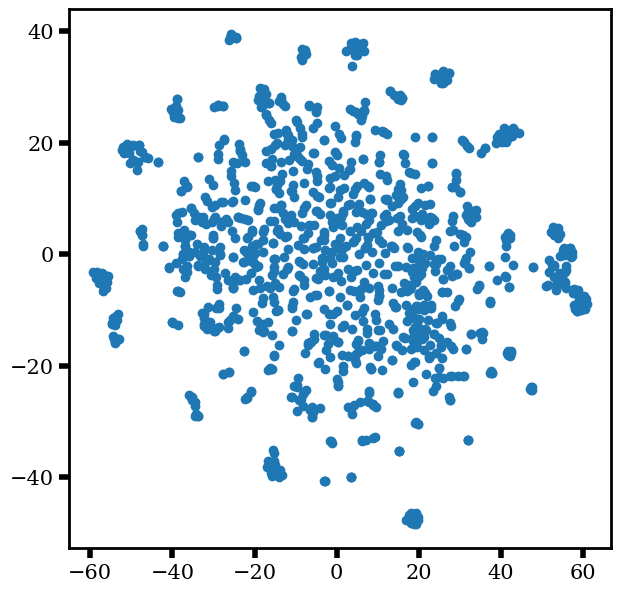

In [8]:
plt.scatter(data=df,x="tsne_x", y="tsne_y")
plt.tick_params(axis='both',labelsize='15', length=7, width=4)